<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/exoplanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exoplanet Research**

In [141]:
!pip install lightkurve astroquery -q
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astroquery.vizier import Vizier
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

###### <font color="blue">*Select Object*

In [142]:
########################################
# Select Exoplanet System
########################################

#target = 'Trappist-1'  # 38.8 light-years
target = 'K2-18'        # 124 light-years
#target = 'K2-18 b'
#target = 'Kepler-10'   # 610 light-years
#target = 'Kepler-8'    # 3,300 light-years
#target = 'HR8799'      # 133 light-years

In [ ]:
########################################
# Explore NASA database
########################################

print(f"--- NASA 'pscomppars' Table ---")
#data = NasaExoplanetArchive.query_object(target, table="pscomppars")
#print(data.colnames) # show available columns

print("\n" + f"--- NASA 'ps' Table ---")
#data = NasaExoplanetArchive.query_object(target, table="ps")
#print(data.colnames) # show available columns

print("\n" + f"--- Scientific Publications about Exoplanet ---")
#NasaExoplanetArchive.query_object(target)

--- NASA 'pscomppars' Table ---

--- NASA 'ps' Table ---

--- Scientific Publications about Exoplanet ---


In [144]:
########################################
# Query Details about Exoplanet System
########################################

# Connect to NASA database (pscomppars, ps)
data = NasaExoplanetArchive.query_object(target, table="ps")

print("\n" + 65*"=" + "\n" + f"\nEXOPLANET: {target}")

print("\n" + 65*"=" + "\n☀️ Host Star\n" + 65*"-")
print(f"Temperature:          {data['st_teff'][0]} (Kelvin)")
print(f"Size:                 {data['st_rad'][0]}  (Solar radii)")
print(f"Luminosity:           {data['st_lum'][0]} (how much energy it puts out)")
print(f"Age:                  {data['st_age'][0]} (Billions of years)")

print("\n" + 65*"=" + "\n🪐 Exoplanet\n" + 65*"-")
print(f"Discovery Year:       {data['disc_year'][0]}")
print(f"Discovery Method:     {data['discoverymethod'][0]}")
print(f"Discovery Telescope:  {data['disc_facility'][0]}")
print(f"Distance:             {((data['sy_dist'][0])* 3.26):.0f} Light Years") # 1 Parsec ≈ 3.26 Light Years
print(f"Temperature:          {data['pl_eqt'][0]} (Equilibrium)")
print(f"Semi-major axis:      {data['pl_orbsmax'][0]} (Distance from its star in AU)")
print(f"Orbital Period:       {data['pl_orbper'][0]} (Days)")
print(f"Planet Radius:        {data['pl_rade'][0]} (Earth Radii)")
print(f"Planet Mass:          {data['pl_masse'][0]} (Earth Masses)")
print(f"Density (Rock/Gas):   {data['pl_dens'][0]}")



EXOPLANET: K2-18

☀️ Host Star
-----------------------------------------------------------------
Temperature:          3457.0 K (Kelvin)
Size:                 0.411 Rsun  (Solar radii)
Luminosity:           nan (how much energy it puts out)
Age:                  nan Gyr (Billions of years)

🪐 Exoplanet
-----------------------------------------------------------------
Discovery Year:       2017
Discovery Method:     Radial Velocity
Discovery Telescope:  La Silla Observatory
Distance:             124 pc Light Years
Temperature:          363.0 K (Equilibrium)
Semi-major axis:      0.06 AU (Distance from its star in AU)
Orbital Period:       8.962 d (Days)
Planet Radius:        nan earthRad (Earth Radii)
Planet Mass:          nan earthMass (Earth Masses)
Density (Rock/Gas):   nan g / cm3


In [ ]:
########################################
# Search for Mission Data
########################################

# TPF raw data with Lightkurve to get telescope data (light curves and pixel files)
print(65*"=" + f"\n🪐 Exoplanet Missions for Object {target} \n" + 65*"-")
pixelfile_info = lk.search_targetpixelfile(target)
# Select only one quarter of Kepler data for star like Kepler-8
#pixelfile_info = lk.search_targetpixelfile("Kepler-8", author="Kepler", quarter=4, cadence="long")
print(pixelfile_info)
print("\n" + 65*"=" + "\n🛰️ TESS (Transiting Exoplanet Survey Satellite)\n" + 65*"-")
search = lk.search_lightcurve(target, mission="TESS")
print(search)
print("\n" + 65*"=" + "\n🛰️ K2 (Mission 2014–2018)\n" + 65*"-")
search = lk.search_lightcurve(target, mission="K2")
print(search)
print("\n" + 65*"=" + "\n🛰️ Kepler (Mission 2009–2013)\n" + 65*"-")
search = lk.search_lightcurve(target, mission="Kepler")
print(search)

🪐 Exoplanet Missions for Object K2-18 
-----------------------------------------------------------------
SearchResult containing 8 data products.

 #     mission     year   author  exptime  target_name  distance
                                     s                   arcsec 
--- -------------- ---- --------- ------- ------------- --------
  0 K2 Campaign 01 2014        K2    1800 ktwo201912552      0.0
  1 TESS Sector 45 2021      SPOC     120     388804061      0.0
  2 TESS Sector 46 2021      SPOC     120     388804061      0.0
  3 TESS Sector 72 2023      SPOC      20     388804061      0.0
  4 TESS Sector 72 2023      SPOC     120     388804061      0.0
  5 TESS Sector 45 2021 TESS-SPOC     600     388804061      0.0
  6 TESS Sector 46 2021 TESS-SPOC     600     388804061      0.0
  7 TESS Sector 72 2023 TESS-SPOC     200     388804061      0.0

🛰️ TESS (Transiting Exoplanet Survey Satellite)
-----------------------------------------------------------------
SearchResult containing

###### <font color="blue">*File Data Analysis*

In [ ]:
# Find Catalogue data with Vizier
catalog_list = Vizier.find_catalogs('hot jupiter exoplanet transit')
for k, v in catalog_list.items():
    print(k, ":", v.description)

J/ApJ/788/39 : Hot Jupiter exoplanets host stars EW and abundances (Teske+, 2014)
J/A+A/635/A122 : CoRoT-30b and CoRoT-31b radial velocity curves (Border+, 2020)
J/A+A/635/A205 : Ultra-hot Jupiter WASP-121b transits (Bourrier+, 2020)
J/AJ/157/217 : Transit times of five hot Jupiter WASP exoplanets (Bouma+, 2019)


In [ ]:
# Query an object
interesting_table = result['J/A+A/635/A205']
print(interesting_table)

In [ ]:
vizier = Vizier()
result = vizier.query_object("sirius")
print(result)

In [ ]:
# Query an object
interesting_table = result['J/MNRAS/504/5813/tablec4']
print(interesting_table)

  Name     Evol  ...                   Refs                   SimbadName
                 ...                                                    
-------- ------- ... ---------------------------------------- ----------
HD48915A A1V(MS) ... Petit et al. (2011), Royer et al. (2002)   HD48915A


In [ ]:
# Query an object
interesting_table = result['IX/8/catalog']
print(interesting_table)

   2XRS     RAB1950      DEB1950    Xname ... Int   _RA.icrs     _DE.icrs  
                                          ... uJy                          
--------- ------------ ------------ ----- ... --- ------------ ------------
06429-166 06 42 54.000 -16 39 00.00       ...  -- 06 45 08.088 -16 42 11.29
06429-166 06 42 54.000 -16 39 00.00       ...  -- 06 45 08.088 -16 42 11.29


In [ ]:
# Query a region
#result = Vizier.query_region("3C 273", radius=angle(0.1, "deg"), catalog='GSC')
result = Vizier.query_region("3C 273", radius="0d6m0s", catalog='GSC')
# result = Vizier.query_region("3C 273", radius=0.1*u.deg, catalog='GSC')

print(result)

TableList with 5 tables:
	'0:I/254/out' with 10 column(s) and 17 row(s) 
	'1:I/255/out' with 9 column(s) and 17 row(s) 
	'2:I/271/out' with 11 column(s) and 50 row(s) 
	'3:I/305/out' with 11 column(s) and 50 row(s) 
	'4:I/353/gsc242' with 35 column(s) and 50 row(s) 


###### <font color="blue">*Load Mission Data*

In [145]:
# Load lightcurve proprocessed data for target exoplanet system
lightcurve_tess = lk.search_lightcurve(target, mission="TESS").download(quality_bitmask="default")
lightcurve_tess

/usr/local/lib/python3.12/dist-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2526.279487983408,———,———,-3.2198639e-03,935156,587.78185,1008.06054,3.7366094e+03,3.0249483e+01,5.6605594e+04,1.5308010e+01,———,———,1000000000000,———,———,———,———,587.78185,4.9652355e-03,1008.06054,5.3632273e-03,-4.6406765e-03,1.4816496e-01
2526.2808769841363,———,———,-3.2197514e-03,935157,587.77353,1008.04962,3.7598357e+03,2.9207094e+01,5.2545727e+04,1.4754713e+01,———,———,1000000000000,———,———,———,———,587.77353,4.7574583e-03,1008.04962,5.1426007e-03,-1.2197427e-02,1.4925280e-01
2526.282265984864,———,———,-3.2196390e-03,935158,587.77692,1008.04883,3.8219690e+03,2.8191071e+01,4.8689441e+04,1.4212725e+01,———,———,1000000000000,———,———,———,———,587.77692,4.5185830e-03,1008.04883,4.8798872e-03,-8.8887801e-03,1.4950117e-01
2526.2836549855924,———,———,-3.2195265e-03,935159,587.77068,1008.05960,3.8348540e+03,2.7147633e+01,4.4933551e+04,1.3650958e+01,———,———,1000000000000,———,———,———,———,587.77068,4.3299841e-03,1008.05960,4.6867882e-03,-2.1032174e-03,1.5436953e-01
2526.285043986321,———,———,-3.2194140e-03,935160,587.77856,1008.04804,3.8357878e+03,2.6068590e+01,4.1193941e+04,1.3073683e+01,———,———,1000000000000,———,———,———,———,587.77856,4.1596340e-03,1008.04804,4.4928021e-03,-2.7236619e-03,1.5193376e-01
2526.2864329870495,———,———,-3.2193016e-03,935161,587.76790,1008.04998,3.7756436e+03,2.4978851e+01,3.7605230e+04,1.2495421e+01,———,———,1000000000000,———,———,———,———,587.76790,4.0394412e-03,1008.04998,4.3718624e-03,-8.9092180e-03,1.4737244e-01
2526.28782198801,———,———,-3.2191889e-03,935162,587.77521,1008.05575,3.8014358e+03,2.3970703e+01,3.4370980e+04,1.1951579e+01,———,———,1000000000000,———,———,———,———,587.77521,3.8522207e-03,1008.05575,4.1657109e-03,-7.3867021e-03,1.5120973e-01
2526.2892109887384,———,———,-3.2190764e-03,935163,587.77229,1008.05685,3.7779231e+03,2.3047329e+01,3.1544006e+04,1.1464765e+01,———,———,1000000000000,———,———,———,———,587.77229,3.7222973e-03,1008.05685,4.0282188e-03,-1.1421268e-02,1.4531696e-01


In [ ]:
########################################
# Load Data
########################################

# Load SPOC data if available
pixelfile_info_tes = pixelfile_info[(pixelfile_info.author == "SPOC") & (pixelfile_info.exptime == 120*u.second)][0].download()
pixelfile_info_tes

# Load Kepler K2 data if available
pixelfile_info_kep = pixelfile_info[(pixelfile_info.author == "K2") & (pixelfile_info.exptime == 60*u.second)][0].download()
pixelfile_info_kep

# Load Kepler data if available
pixelfile_info_kep = pixelfile_info[(pixelfile_info.author == "Kepler") & (pixelfile_info.exptime == 60*u.second)][0].download()
pixelfile_info_kep

# FINAL Load TPF raw data for target exoplanet system
pixelfile = lk.search_targetpixelfile(target)[1].download()
pixelfile

# Pull more info of TPF file
pixelfile.get_header(ext=0)

In [ ]:
# Load SPOC data if available
pixelfile_info_tes = pixelfile_info[(pixelfile_info.author == "SPOC") & (pixelfile_info.exptime == 120*u.second)][0].download()
pixelfile_info_tes

In [ ]:
# Load Kepler K2 data if available
pixelfile_info_kep = pixelfile_info[(pixelfile_info.author == "K2") & (pixelfile_info.exptime == 60*u.second)][0].download()
pixelfile_info_kep

In [ ]:
# Load Kepler data if available
pixelfile_info_kep = pixelfile_info[(pixelfile_info.author == "Kepler") & (pixelfile_info.exptime == 60*u.second)][0].download()
pixelfile_info_kep

In [147]:
# Load TPF raw data for target exoplanet system
pixelfile = lk.search_targetpixelfile(target)[1].download()
pixelfile

TessTargetPixelFile(TICID: 388804061)

In [148]:
# Pull more info of TPF file
pixelfile.get_header(ext=0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    3 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2021-12-10'         / file creation date.                            
TSTART  =    2526.278793598669 / observation start time in BTJD                 
TSTOP   =    2550.624096547463 / observation stop time in BTJD                  
DATE-OBS= '2021-11-07T18:40:

###### <font color="blue">*Visualization from raw TFP file*

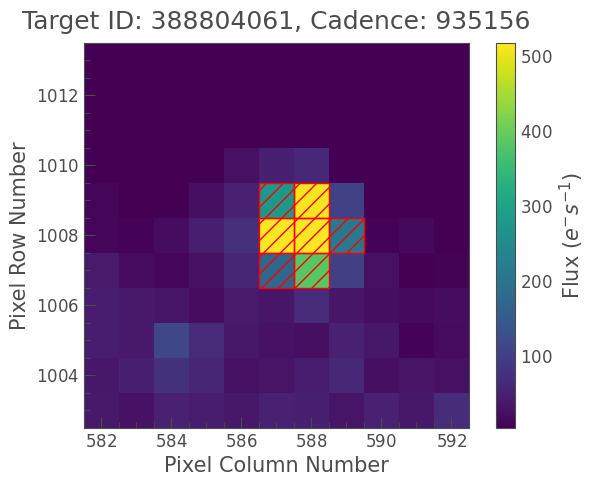

In [149]:
# Visualize TESS data if available
pixelfile_info_tes.plot(aperture_mask=pixelfile_info_tes.pipeline_mask)
fig = plt.gcf()
fig.set_size_inches(7, 5)
plt.show()

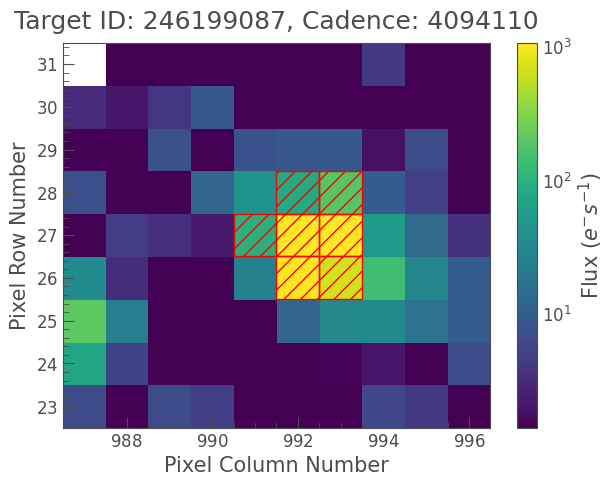

In [ ]:
# Visualize Kepler data if available
pixelfile_info_kep.plot(aperture_mask=pixelfile_info_kep.pipeline_mask, scale='log')
fig = plt.gcf()
fig.set_size_inches(7, 5)
plt.show()

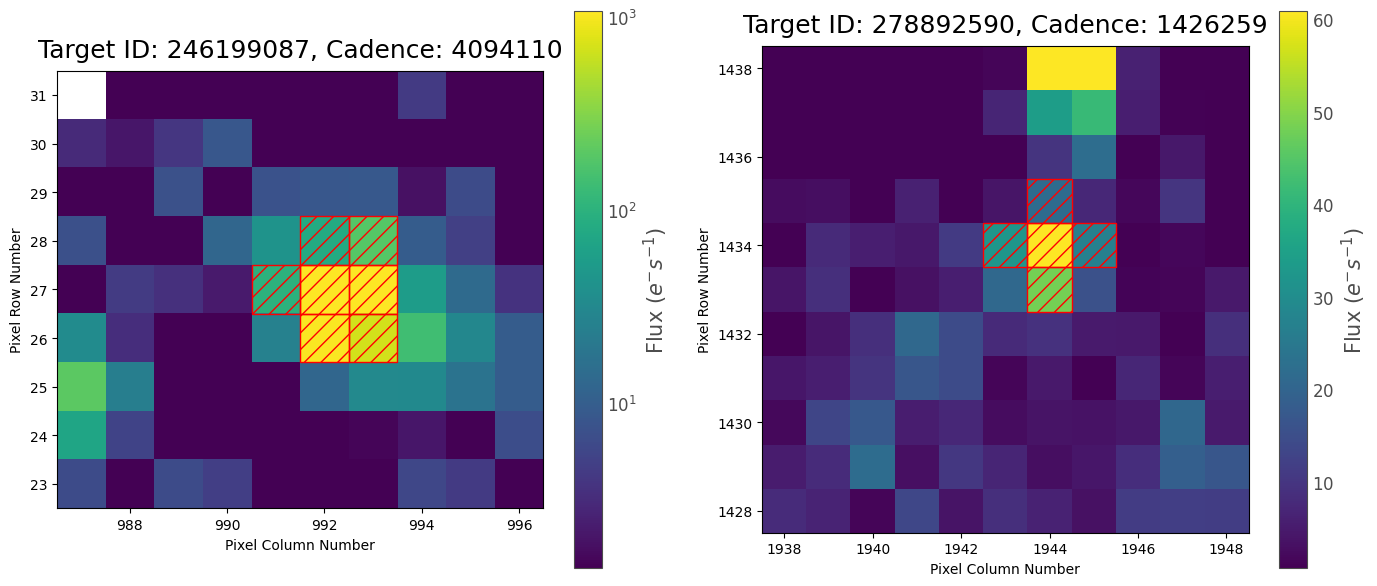

In [ ]:
# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14,6))
pixelfile_info_kep.plot(ax=axes[0], aperture_mask=pixelfile_info_kep.pipeline_mask, scale='log')
pixelfile_info_tes.plot(ax=axes[1], aperture_mask=pixelfile_info_tes.pipeline_mask)
fig.tight_layout();

In [ ]:
# Visualize how the target star's brightness evolves over time (Animate Exoplanet Movement)
pixelfile.animate()

<Axes: title={'center': 'Visualize Trappist-1'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

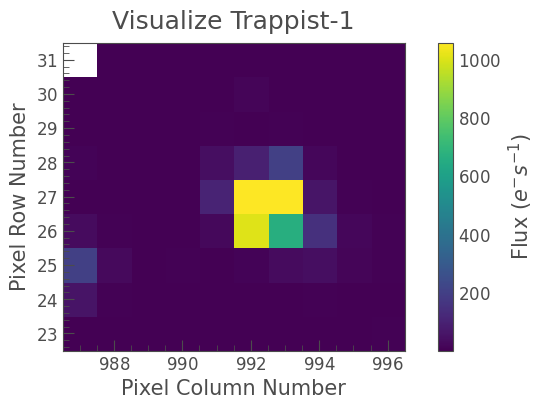

In [ ]:
# Visualize pixelfile data
pixelfile.plot(title=f"Visualize {target}")

###### <font color="blue">*Transit fitting, period finding, and light curve analysis*

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

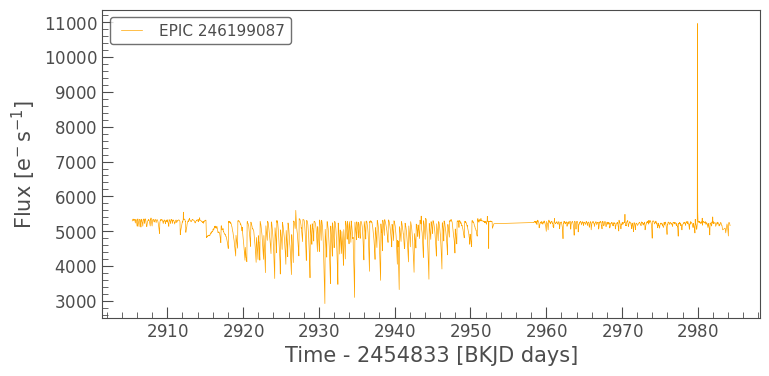

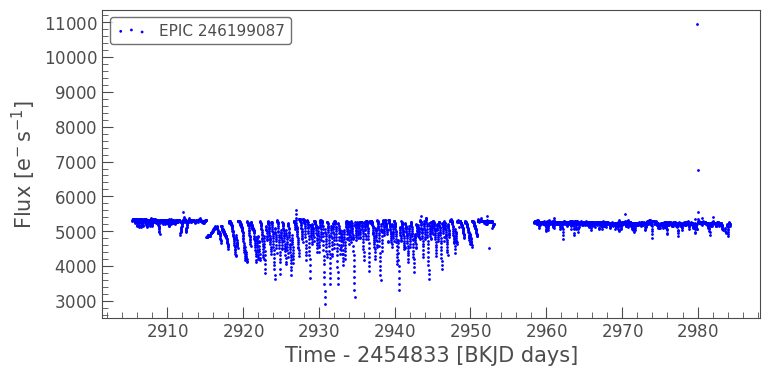

In [ ]:
# Create lightcurve from raw data
pixelfile.to_lightcurve().plot(color='orange')
pixelfile.to_lightcurve().scatter(color='blue')

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

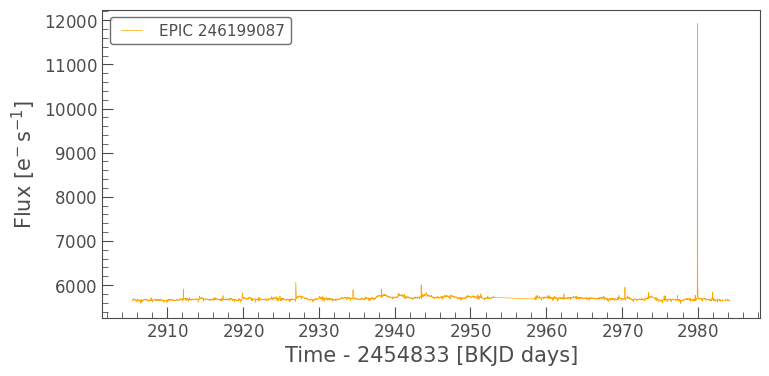

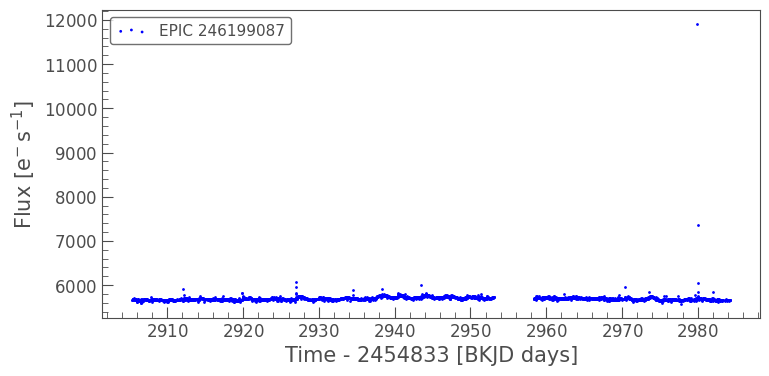

In [ ]:
# Remove noise
pixelfile.to_lightcurve(method="pld").plot(color='orange')
pixelfile.to_lightcurve(method="pld").scatter(color='blue')

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

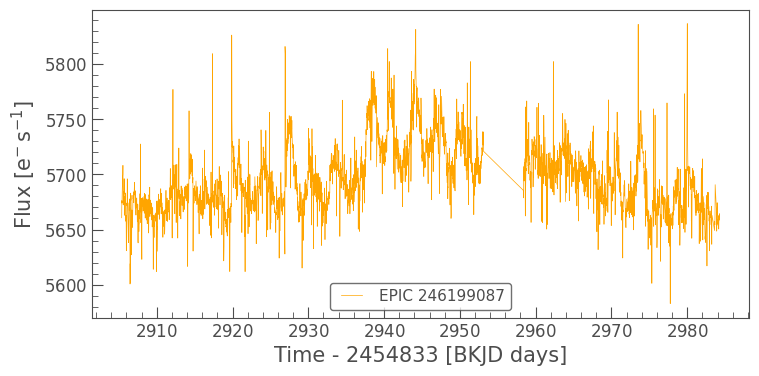

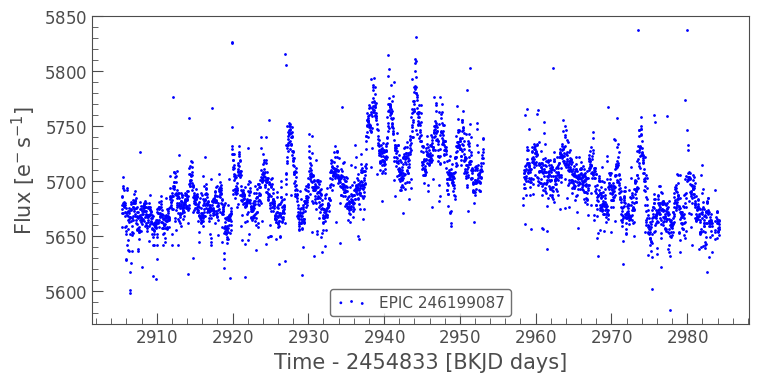

In [ ]:
# Remove outliers
pixelfile.to_lightcurve(method="pld").remove_outliers().plot(color='orange')
pixelfile.to_lightcurve(method="pld").remove_outliers().scatter(color='blue')

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

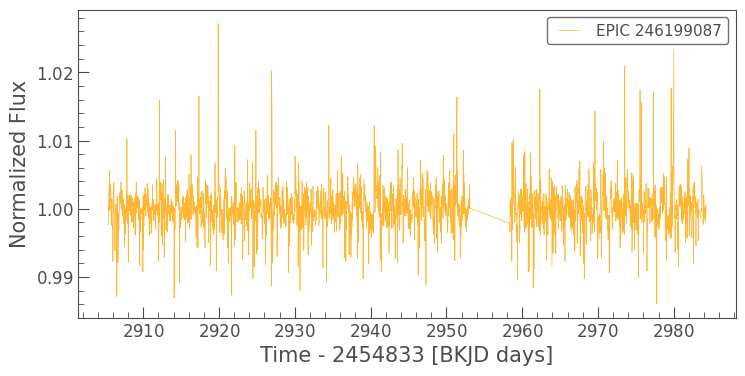

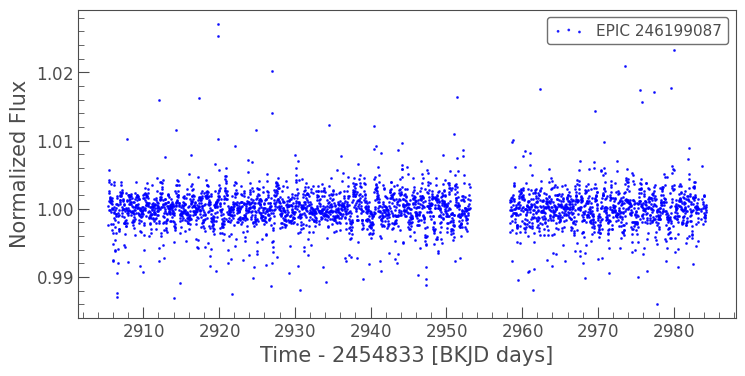

In [ ]:
# Normalize
pixelfile.to_lightcurve(method="pld").remove_outliers().flatten().plot(c='orange', alpha=.8)
pixelfile.to_lightcurve(method="pld").remove_outliers().flatten().scatter(c='b', alpha=.8)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

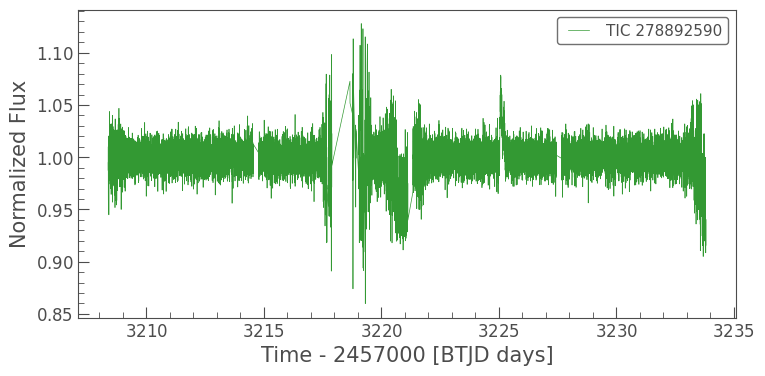

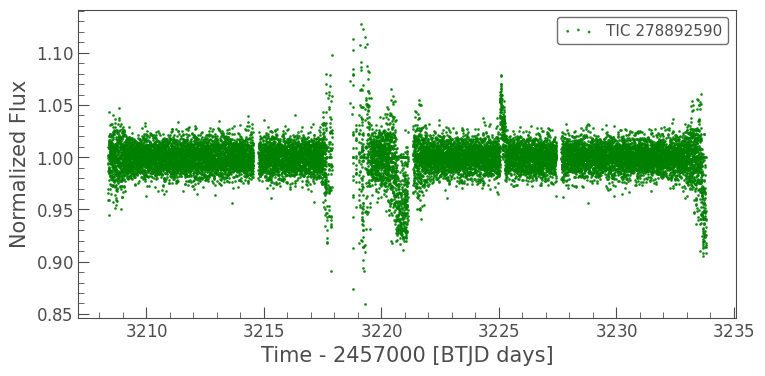

In [ ]:
# Compare with data from TESS (the other data is EPIC 246199087 whcih is from K2 | TIC 278892590 is from TESS)
pixelfile_info_tes.to_lightcurve(method="pld").remove_outliers().flatten().plot(c='green', alpha=.8)
pixelfile_info_tes.to_lightcurve(method="pld").remove_outliers().flatten().scatter(c='green', alpha=.8)

###### <font color="blue">*Analyse Periodogram*

<Axes: title={'center': 'Periodogram - Transit Detection'}, xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

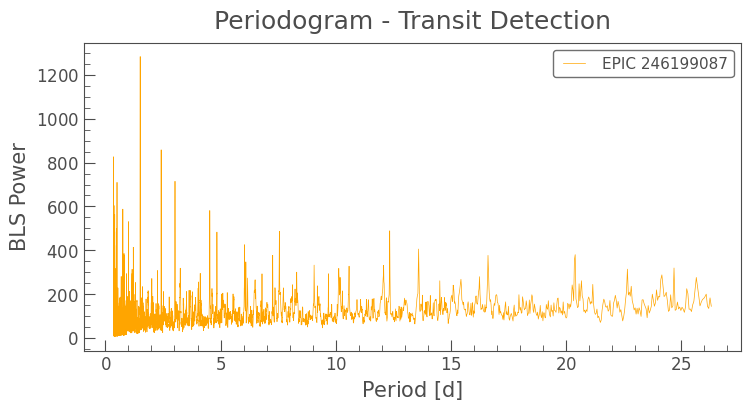

In [ ]:
# Create Periodogram for Transit Detection
periodogram = pixelfile.to_lightcurve(method="pld").remove_outliers().flatten()
periodogram.to_periodogram("bls").plot(title="Periodogram - Transit Detection", color='orange')

Period at max power: 1.5110372927644626 d


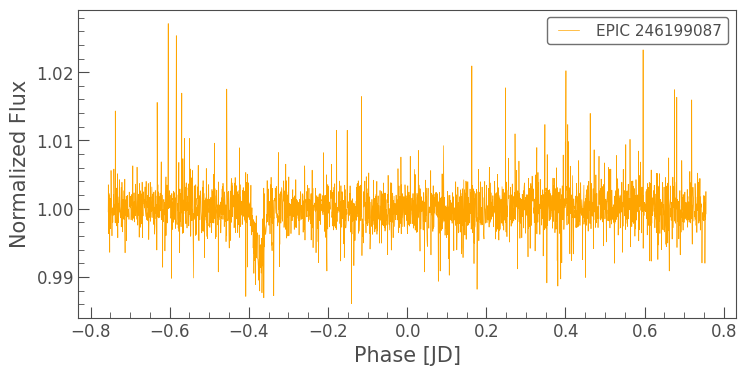

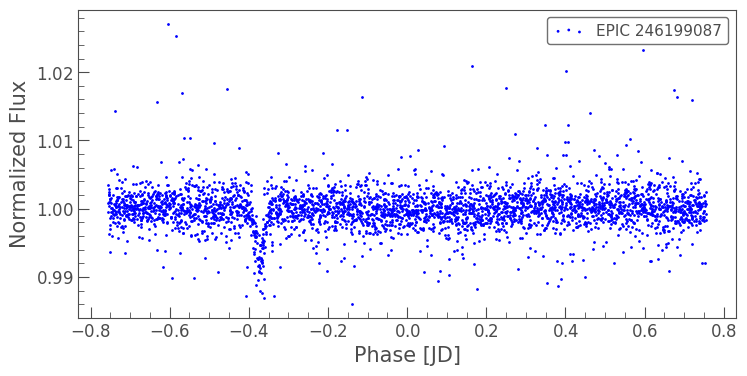

In [ ]:
# Normalize and get period at max power
period = periodogram.to_periodogram("bls").period_at_max_power
periodogram.fold(period).plot(color='orange')
periodogram.fold(period).scatter(color='blue')
print(f"Period at max power: {period}")

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

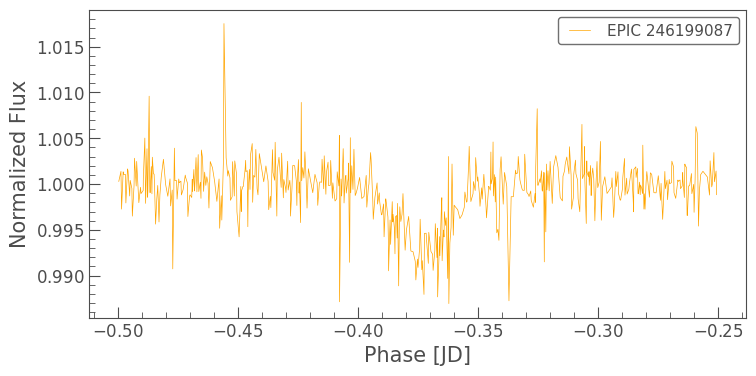

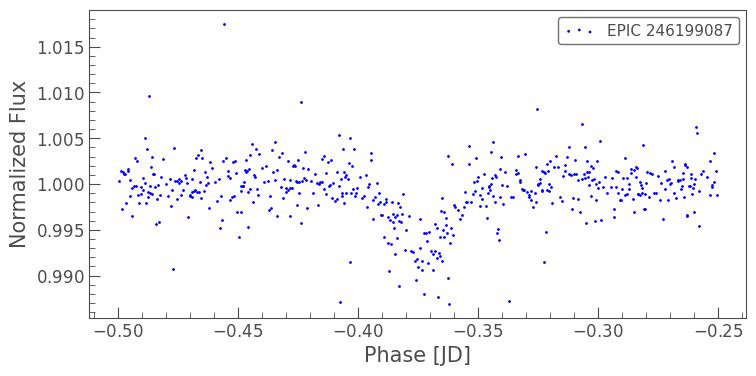

In [ ]:
# Zoom in and focus on dip in lightcurve (at x-axis)
periodogram.fold(period).truncate(-0.5, -0.25).plot(color='orange')
periodogram.fold(period).truncate(-0.5, -0.25).scatter(color='blue')

<Axes: title={'center': 'Periodogram - Transit Detection'}, xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

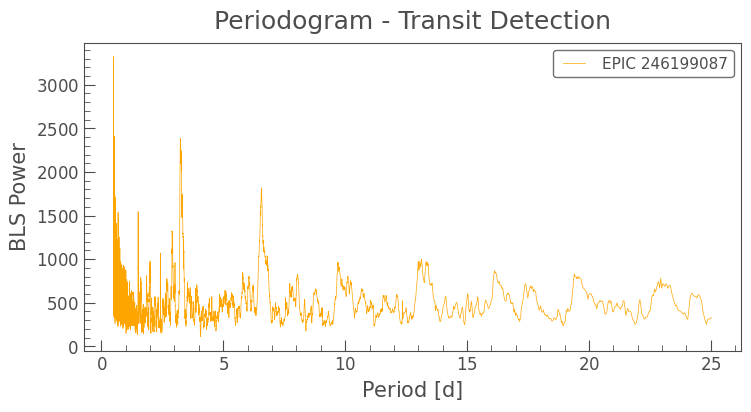

In [ ]:
# Clean the data by removing NaN values and flattening the curve
cleaned_lc = pixelfile.to_lightcurve(method="pld").remove_nans().flatten(window_length=401)

# Detect transits: Use a Box Least Squares (BLS) periodogram to find periodic dips in brightness, which could indicate planetary transits
periodogram = cleaned_lc.to_periodogram(method="bls", minimum_period=0.5, maximum_period=25)

# Plot the BLS periodogram to visualize detected periods (periodogram helps to visualize and extract the best-fit period, i.e. the time between transits
periodogram.plot(title="Periodogram - Transit Detection", color='orange')

In [ ]:
# Get the best-fit transit period and duration
best_fit_period = periodogram.period_at_max_power
best_fit_duration = periodogram.duration_at_max_power
best_fit_depth = periodogram.depth_at_max_power

print(f"Best-fit period: {best_fit_period:.2f} days")
print(f"Best-fit transit duration: {best_fit_duration:.2f} days")
print(f"Transit depth: {best_fit_depth:.6f} relative flux")

Best-fit period: 0.50 d days
Best-fit transit duration: 0.33 d days
Transit depth: 0.001522 relative flux


<Axes: title={'center': 'Folded Light Curve for Trappist-1 - Period: 0.50 d days'}, xlabel='Phase [JD]', ylabel='Normalized Flux'>

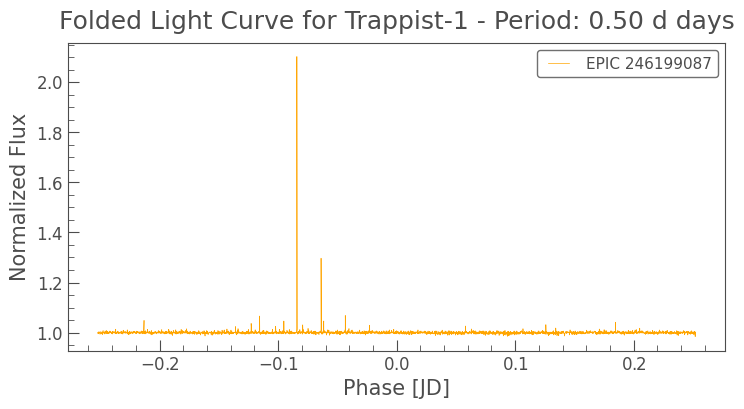

In [ ]:
# Generate "phase-folded light curve" by detected period to observe repeated transits more clearly ("fold" light curve data over a single period)
# This overlays all transit events on top of each other, allowing to clearly see recurring transit in one cycle
folded_lc = cleaned_lc.fold(period=best_fit_period.value)
folded_lc.plot(title=f"Folded Light Curve for {target} - Period: {best_fit_period:.2f} days", color='orange')

In [ ]:
# Estimate the planet radius (using transit depth and star's radius)
# Rp = planet radius, Rs = star radius, depth = fractional dip in brightness
star_radius = 1.065  # Solar radii for Kepler-10
planet_radius = star_radius * np.sqrt(best_fit_depth) # Formula: (Rp/Rs)^2 = depth
print(f"Estimated planet radius: {planet_radius:.2f} solar radii")

Estimated planet radius: 0.04 solar radii
